In [1]:
import datetime as dt
from pathlib import Path
from typing import Union, Callable, Optional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pytorch_lightning as pl
import sunpy.data.sample
import sunpy.map
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from solarnet.data.sdo_benchmark_dataset import SDOBenchmarkDataset
from solarnet.models.naive import naive_predictions_majority_class, naive_predictions_random_guess
from solarnet.utils.dict import print_dict
from solarnet.utils.metrics import classification_metrics
from solarnet.utils.target import flux_to_class_builder

Sunpy

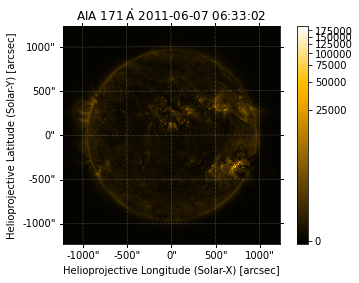

In [2]:
aia = sunpy.map.Map(sunpy.data.sample.AIA_171_IMAGE)
aia.peek()

SDO dataset - *A Machine-learning Data Set Prepared from the NASA Solar Dynamics Observatory Mission*

- MiniSDO dataset - ~35 GB per year
- Complete dataset - ~720 GB per year (total ~= 6.5 TB)

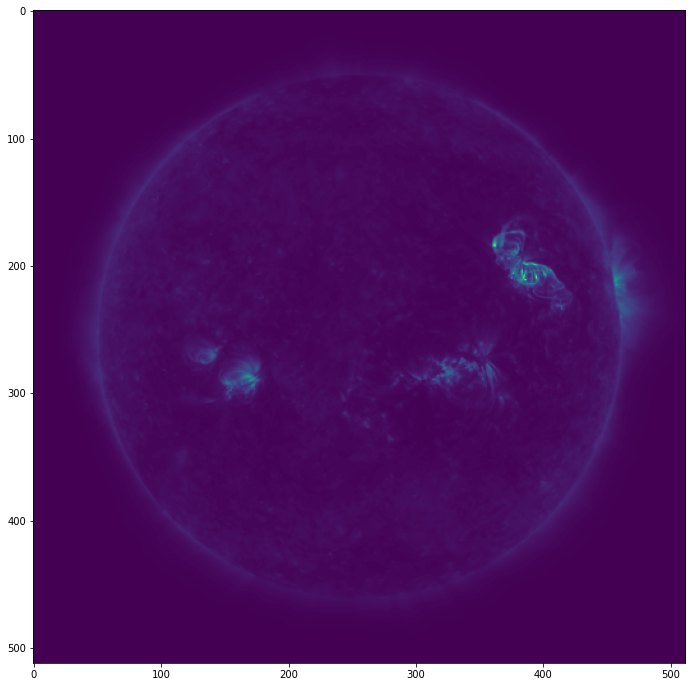

In [3]:
# MiniSDO sample

dfile = "E:/data/minisdo/SDO_MINI/2017/AIA/0171/09/06/AIA20170906_1624_0171.npz"
images = np.load(dfile)["x"].astype(np.float64)
plt.figure(figsize=(12, 12))
# plt.imshow(images, cmap='gray');
plt.imshow(images);

SDOBenchmark dataset

- Total ~= 3 GB
- ~8000 samples
- Includes labels (peak flux)

In [4]:
csv_file = Path('E:/data/sdobenchmark/training/meta_data.csv')
metadata = pd.read_csv(csv_file, parse_dates=['start', 'end'])
metadata.head()

,id,start,end,peak_flux
0,11390_2012_01_05_17_06_01_0,2012-01-05 05:06:01,2012-01-05 17:06:01,8.000000e-07
1,11390_2012_01_05_17_19_01_0,2012-01-05 05:19:01,2012-01-05 17:19:01,1.647059e-06
2,11390_2012_01_05_17_19_01_1,2012-01-06 05:19:00,2012-01-06 17:19:00,1.647059e-06
3,11390_2012_01_06_17_20_58_0,2012-01-06 05:20:58,2012-01-06 17:20:58,1.164706e-06
4,11390_2012_01_04_07_22_01_0,2012-01-03 19:22:01,2012-01-04 07:22:01,2.235294e-06


In [5]:
transform = transforms.Compose([
    # transforms.ToTensor()
])

ds_path = Path('E:/data/sdobenchmark/training')
metadata_path = ds_path / 'meta_data.csv'
ds = SDOBenchmarkDataset(metadata_path, ds_path, transform=transform, channel='171')

print(f'Number of samples: {len(ds)}')

Number of samples: 7918


Peak flux: 1e-09


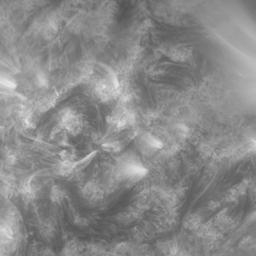

In [6]:
sample = 221
print(f'Peak flux: {ds[sample][1]}')
ds[sample][0]

<AxesSubplot:ylabel='Count'>

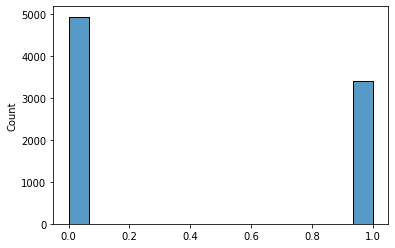

In [7]:
classes_bin = [
    {"Quiet": "< 1e-6"},
    {">=C": ">= 1e-6"},
]
flux_to_class = flux_to_class_builder(classes_bin)
classes = [flux_to_class(f) for f in metadata.peak_flux.values]
sns.histplot(classes)

(array([0, 1, 2, 3]), array([4931, 2891,  479,   35], dtype=int64))

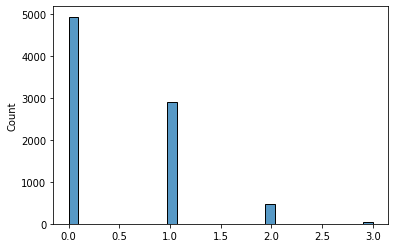

In [8]:
classes_multi = [
    {"Quiet": "< 1e-6"},
    {"C": "< 1e-5"},
    {"M": "< 1e-4"},
    {"X": ">= 1e-4"},
]
flux_to_class = flux_to_class_builder(classes_multi)
classes = [flux_to_class(f) for f in metadata.peak_flux.values]
sns.histplot(classes);
np.unique(classes, return_counts=True)

## Naive predictions

In [9]:
classes = classes_bin
n_class = len(classes)
seed = 42

In [10]:
ds_path = Path("../data/sdo-benchmark")
ds = SDOBenchmarkDataset(
    ds_path / 'test' / 'meta_data.csv',
    ds_path / 'test',
    transform=None,
    target_transform=flux_to_class_builder(classes),
    channel='171',
)
ls = [i[1] for i in ds]
y = torch.tensor(ls)
len(ds)

875

In [11]:
print("Random guess")
y_pred = naive_predictions_random_guess(len(ds), n_class, seed)
print_dict(classification_metrics(y, y_pred, n_class=n_class), precision=3)

print("\nMajority class")
y_pred = naive_predictions_majority_class(len(ds))
print_dict(classification_metrics(y, y_pred, n_class=n_class), precision=3)

Random guess
    accuracy: 0.507
    balanced_accuracy: 0.506
    f1: 0.502
    far: 0.399
    hss: 0.011
    pod: 0.514
    csi: 0.383
    tss: 0.012

Majority class
    accuracy: 0.405
    balanced_accuracy: 0.500
    f1: 0.288
    far: 1.000
    hss: 0.000
    pod: 0.000
    csi: 0.000
    tss: 0.000
